In [ ]:
# pip install chronos-forecasting

In [ ]:
# pip install seaborn

## Implementation TSMixup

Algorithm I TSMixup: Time Series Mixup
Input: Time series datasets ${1, ... ,X_{N_{a}}}$, maximum time series to be mixed K = 3, symmetric Dirichlet
concentration parameter $\alpha=1.5$, and (minimum, maximum) length of the augmented time series ($l_{min} =
128, l_{max} = 2048)$.
Output: An augmented time series.

1: k~$U\{1,K\}$     number of time series to mix

2: l ~ $U\{l_{min}, l_{max}\}$  length of the augmented time series

3: for i <-- 1, k do

4:      n ~ $U\{1, N_a\}$     sample a dataset index

5:      $x^{(i)}_{1:l}$ ~ $X_n$     sample a time series of length l from dataset n

6:      $x^{(i)}_{1:l}$ <-- apply mean scaling to the time series

7: end for

8: [A1, ... ,Ak]~Dir([$\alpha_1=a, ... ,\alpha_k=a$])  take weighted combination of time series

9: return the weighted combination of time series



In [6]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def tsMixup(Time_Series_Dataset, k_max=3, alpha=1.5, l_min=128, l_max=2048, plot=True):
    # Step 1: Determine k (number of series to mix)
    k = random.randint(1, min(k_max, len(Time_Series_Dataset)))  # Ensure k doesn't exceed available series
    print(k)

    # Step 2: Find min and max lengths
    lengths = [ts.shape[0] for ts in Time_Series_Dataset]
    l_max = min(min(lengths), l_max)

    # Step 3: Sample l within valid range
    l = random.randint(l_min, l_max)

    # Step 4: Extract l-length samples from each time series
    sampled_series = []
    original_segments = []  # To store the extracted segments for visualization

    # Counter i
    i = 1

    for ts in Time_Series_Dataset:
        if i > k:
            break
        i += 1
        max_start = max(0, ts.shape[0] - l)
        start_idx = random.randint(0, max_start) if max_start > 0 else 0
        sampled_ts = ts.iloc[start_idx : start_idx + l, 1].values  # Select only data column

        # Mean scaling individuale: dividiamo ogni serie per la propria media dei valori assoluti
        scale_factor = np.mean(np.abs(sampled_ts))
        if scale_factor != 0:
            sampled_ts = sampled_ts / scale_factor  # Normalize only the current series

        sampled_series.append(sampled_ts)
        original_segments.append(sampled_ts.copy())  # Store for plotting

    # Step 5: Generate Dirichlet weights with alpha = 1.5
    weights = np.random.dirichlet([alpha] * k, size=1)[0]

    # Step 6: Perform weighted sample mixing
    mixed_sample = sum(w * s for w, s in zip(weights, sampled_series))

    # Step 7: Plot results
    if plot:
        plt.figure(figsize=(20, 10))

        # Left plot: Mixed time series
        plt.subplot(1, 2, 2)
        plt.plot(mixed_sample, color="black", linewidth=2, label="Mixed Series")
        plt.title("Final Mixed Time Series")
        plt.xlabel("Time")
        plt.ylabel("#Quantity")
        plt.legend()

        # Right plot: Extracted segments
        plt.subplot(1, 2, 1)
        for i, segment in enumerate(original_segments):
            plt.plot(segment, label=f"Segment {i+1} Weight {round(weights[i], 2)}")

        plt.title("Extracted Segments")
        plt.xlabel("Time")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Convert mixed sample back to DataFrame
    return pd.DataFrame({'#Passengers': mixed_sample}), weights

In [8]:
df_passengers = pd.read_csv(
    "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"
)
df_brent_price = pd.read_csv(
    "https://raw.githubusercontent.com/rishabh89007/Time_Series_Datasets/refs/heads/main/Brent%20Spot%20Price.csv"
)
df_passengers.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


2


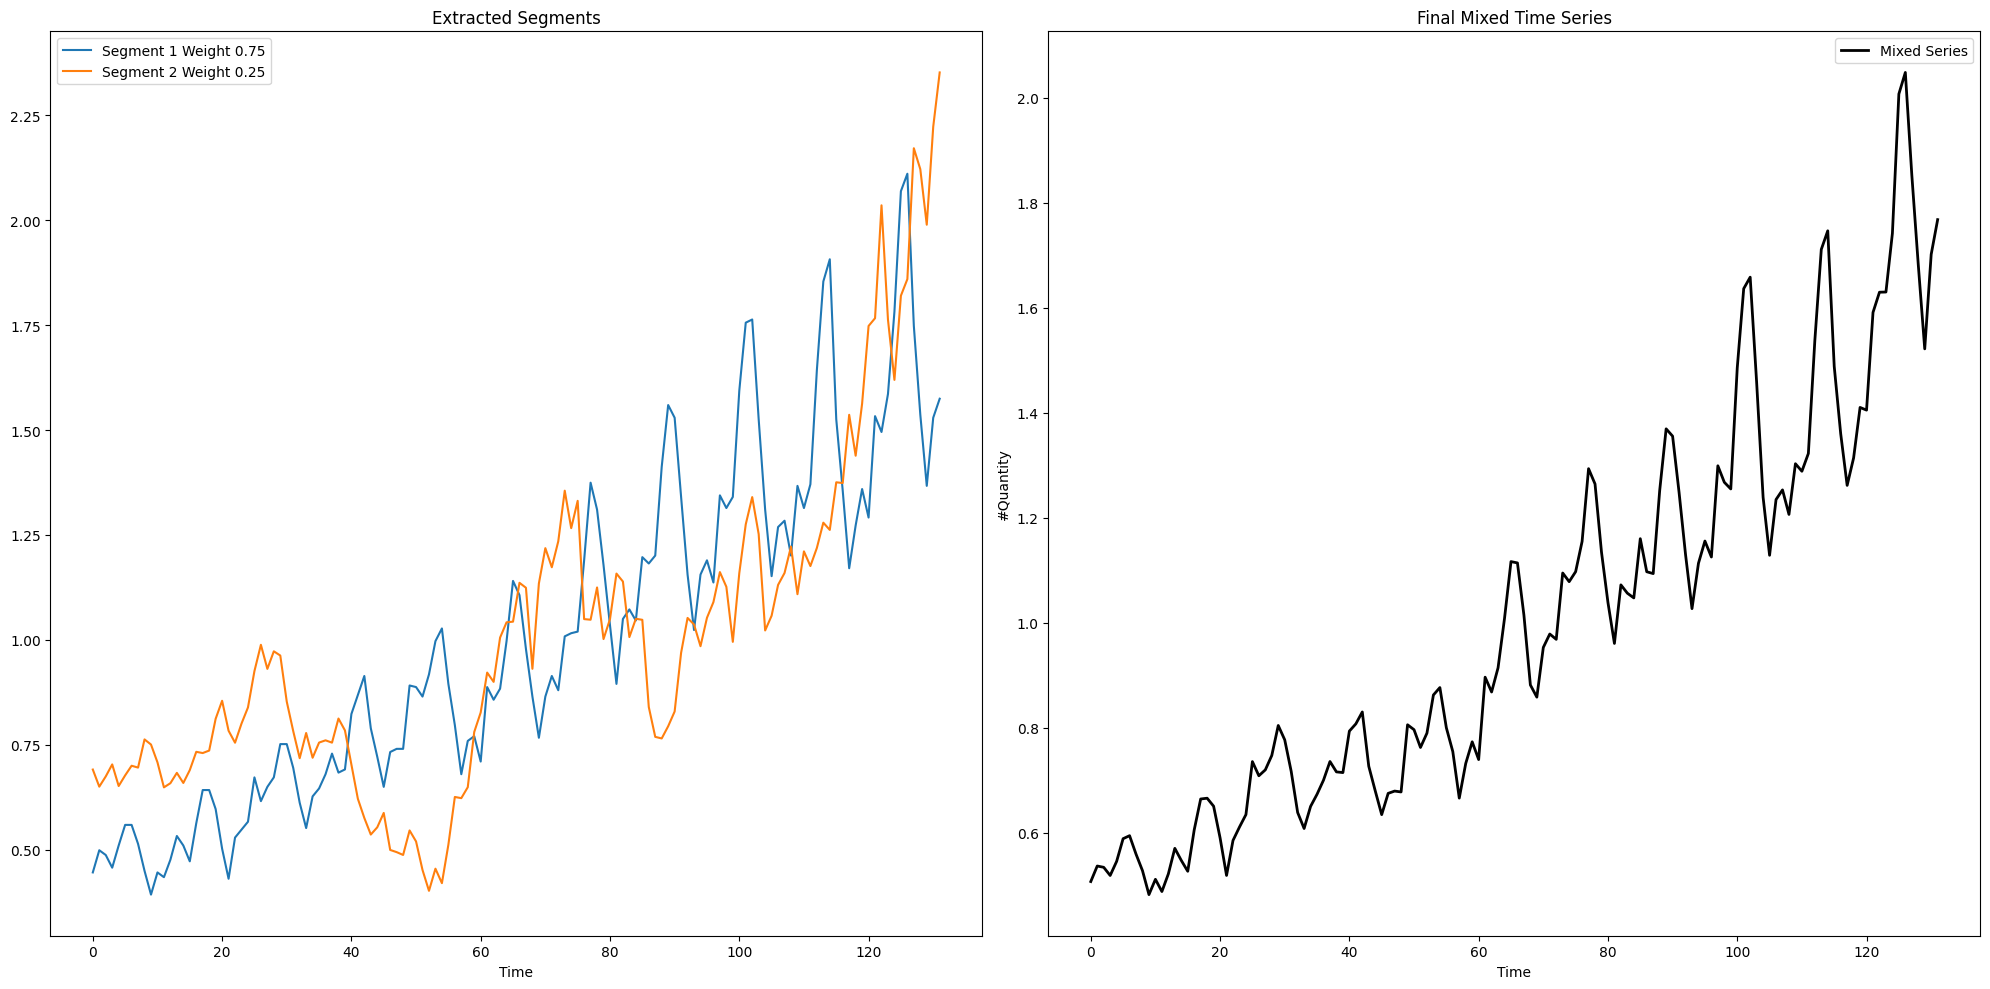

(     #Passengers
 0       0.506570
 1       0.536163
 2       0.533699
 3       0.518123
 4       0.545053
 ..           ...
 127     1.853705
 128     1.682380
 129     1.521766
 130     1.701824
 131     1.768061
 
 [132 rows x 1 columns],
 array([0.75143941, 0.24856059]))

In [11]:
Time_Series_Dataset = [df_passengers, df_brent_price]
tsMixup(Time_Series_Dataset, 5)

## Implementation Kernel-Smith

In [2]:
import argparse
import functools
from pathlib import Path
from typing import Optional

import numpy as np
from gluonts.dataset.arrow import ArrowWriter
from joblib import Parallel, delayed
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    DotProduct,
    ExpSineSquared,
    Kernel,
    RationalQuadratic,
    WhiteKernel,
)
from tqdm.auto import tqdm

LENGTH = 1024
KERNEL_BANK = [
    ExpSineSquared(periodicity=24 / LENGTH),  # H
    ExpSineSquared(periodicity=48 / LENGTH),  # 0.5H
    ExpSineSquared(periodicity=96 / LENGTH),  # 0.25H
    ExpSineSquared(periodicity=24 * 7 / LENGTH),  # H
    ExpSineSquared(periodicity=48 * 7 / LENGTH),  # 0.5H
    ExpSineSquared(periodicity=96 * 7 / LENGTH),  # 0.25H
    ExpSineSquared(periodicity=7 / LENGTH),  # D
    ExpSineSquared(periodicity=14 / LENGTH),  # 0.5D
    ExpSineSquared(periodicity=30 / LENGTH),  # D
    ExpSineSquared(periodicity=60 / LENGTH),  # 0.5D
    ExpSineSquared(periodicity=365 / LENGTH),  # D
    ExpSineSquared(periodicity=365 * 2 / LENGTH),  # 0.5D
    ExpSineSquared(periodicity=4 / LENGTH),  # W
    ExpSineSquared(periodicity=26 / LENGTH),  # W
    ExpSineSquared(periodicity=52 / LENGTH),  # W
    ExpSineSquared(periodicity=4 / LENGTH),  # M
    ExpSineSquared(periodicity=6 / LENGTH),  # M
    ExpSineSquared(periodicity=12 / LENGTH),  # M
    ExpSineSquared(periodicity=4 / LENGTH),  # Q
    ExpSineSquared(periodicity=4 * 10 / LENGTH),  # Q
    ExpSineSquared(periodicity=10 / LENGTH),  # Y
    DotProduct(sigma_0=0.0),
    DotProduct(sigma_0=1.0),
    DotProduct(sigma_0=10.0),
    RBF(length_scale=0.1),
    RBF(length_scale=1.0),
    RBF(length_scale=10.0),
    RationalQuadratic(alpha=0.1),
    RationalQuadratic(alpha=1.0),
    RationalQuadratic(alpha=10.0),
    WhiteKernel(noise_level=0.1),
    WhiteKernel(noise_level=1.0),
    ConstantKernel(),
]


def random_binary_map(a: Kernel, b: Kernel):
    """
    Applies a random binary operator (+ or *) with equal probability
    on kernels ``a`` and ``b``.

    Parameters
    ----------
    a
        A GP kernel.
    b
        A GP kernel.

    Returns
    -------
        The composite kernel `a + b` or `a * b`.
    """
    binary_maps = [lambda x, y: x + y, lambda x, y: x * y]
    return np.random.choice(binary_maps)(a, b)


def sample_from_gp_prior(
    kernel: Kernel, X: np.ndarray, random_seed: Optional[int] = None
):
    """
    Draw a sample from a GP prior.

    Parameters
    ----------
    kernel
        The GP covaraince kernel.
    X
        The input "time" points.
    random_seed, optional
        The random seed for sampling, by default None.

    Returns
    -------
        A time series sampled from the GP prior.
    """
    if X.ndim == 1:
        X = X[:, None]

    assert X.ndim == 2
    gpr = GaussianProcessRegressor(kernel=kernel)
    ts = gpr.sample_y(X, n_samples=1, random_state=random_seed)

    return ts


def sample_from_gp_prior_efficient(
    kernel: Kernel,
    X: np.ndarray,
    random_seed: Optional[int] = None,
    method: str = "eigh",
):
    """
    Draw a sample from a GP prior. An efficient version that allows specification
    of the sampling method. The default sampling method used in GaussianProcessRegressor
    is based on SVD which is significantly slower that alternatives such as `eigh` and
    `cholesky`.

    Parameters
    ----------
    kernel
        The GP covaraince kernel.
    X
        The input "time" points.
    random_seed, optional
        The random seed for sampling, by default None.
    method, optional
        The sampling method for multivariate_normal, by default `eigh`.

    Returns
    -------
        A time series sampled from the GP prior.
    """
    if X.ndim == 1:
        X = X[:, None]

    assert X.ndim == 2

    cov = kernel(X)
    ts = np.random.default_rng(seed=random_seed).multivariate_normal(
        mean=np.zeros(X.shape[0]), cov=cov, method=method
    )

    return ts


def generate_time_series(max_kernels: int = 5):
    """Generate a synthetic time series from KernelSynth.

    Parameters
    ----------
    max_kernels, optional
        The maximum number of base kernels to use for each time series, by default 5

    Returns
    -------
        A time series generated by KernelSynth.
    """
    while True:
        X = np.linspace(0, 1, LENGTH)

        # Randomly select upto max_kernels kernels from the KERNEL_BANK
        selected_kernels = np.random.choice(
            KERNEL_BANK, np.random.randint(1, max_kernels + 1), replace=True
        )

        # Combine the sampled kernels using random binary operators
        kernel = functools.reduce(random_binary_map, selected_kernels)

        # Sample a time series from the GP prior
        try:
            ts = sample_from_gp_prior(kernel=kernel, X=X)
        except np.linalg.LinAlgError as err:
            print("Error caught:", err)
            continue

        # The timestamp is arbitrary
        return {"start": np.datetime64("2000-01-01 00:00", "s"), "target": ts.squeeze()}


c:\Users\picca\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sintetica = generate_time_series(max_kernels=10)
sintetica

{'start': np.datetime64('2000-01-01T00:00:00'),
 'target': array([-1.94160562, -1.74580074, -1.51930329, ...,  0.76287185,
         0.85203534,  0.9220715 ])}

C:\Users\picca\AppData\Local\Temp\ipykernel_23664\841836892.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


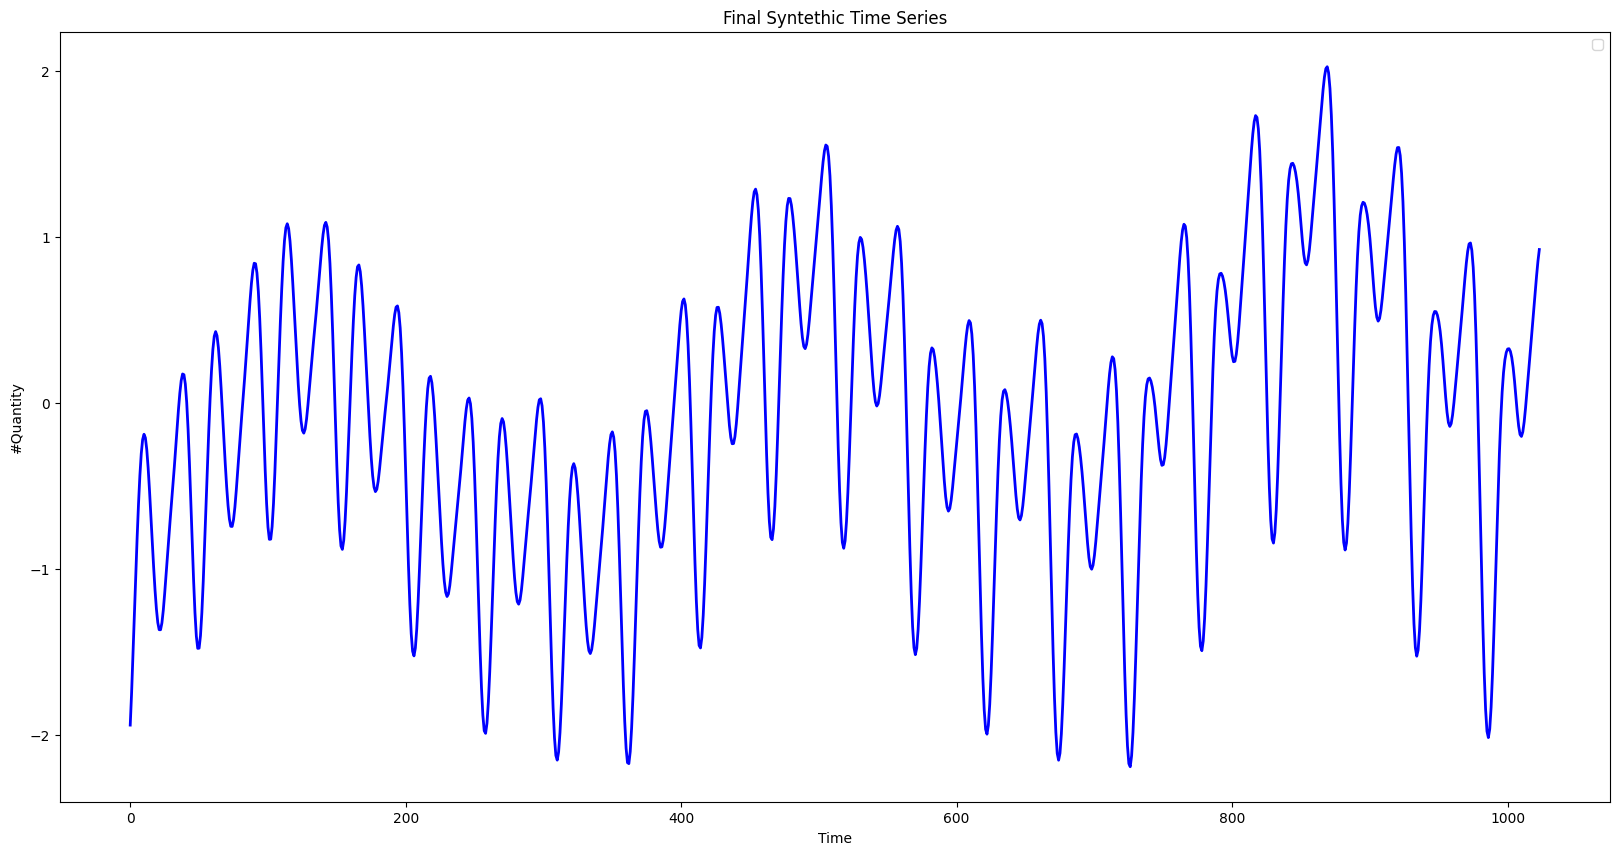

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(sintetica.get("target"), color="blue", linewidth=2)
plt.title("Final Syntethic Time Series")
plt.xlabel("Time")
plt.ylabel("#Quantity")
plt.legend()

## Database australian electricity
Data set has no missing values.
Values are in kW of each 15 min. To convert values in kWh values must be divided by 4.
Each column represent one client. Some clients were created after 2011. In these cases consumption were considered zero.

There are 370 clients.


In [ ]:
df_aus_electricity = pd.read_csv("C:/Users/picca/Documents/Umberto/Deep_natural_language_proc/project/dataset/Energy/AustralianElectricity/LD2011_2014.txt", sep=";", header=0, low_memory=False, nrows=100000)

# Transforming one rows for Customer
# df_aus_electricity.set_index(df_aus_electricity.columns[0], inplace=True)
df_aus_electricity.fillna(0)
df_aus_electricity

,Unnamed: 0,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
1,2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2,2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
3,2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
4,2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2013-11-07 15:00:00,"34,2639593908629","27,7382645803698","1,73761946133797","91,4634146341463","31,7073170731707","205,357142857143","2,82645562464669","272,727272727273","85,6643356643357",...,"419,700214132762",50400.0,"3953,5864978903","6318,18181818182","91,264667535854","9,94733762434172","633,889376646181","135,225375626043","943,548387096774","19740,5405405405"
99996,2013-11-07 15:15:00,"16,497461928934","26,3157894736842","0,868809730668983","99,5934959349593","43,9024390243902","187,5","2,82645562464669","272,727272727273","80,4195804195804",...,"418,986438258387",58900.0,"4037,9746835443","6340,90909090909","89,9608865710561","7,02165008777063","673,397717295874","136,894824707846","922,287390029325","19740,5405405405"
99997,2013-11-07 15:30:00,"15,2284263959391","26,3157894736842","1,73761946133797","93,4959349593496","45,1219512195122","190,47619047619","2,26116449971735","249,158249158249","83,9160839160839",...,"417,558886509636",55200.0,"4088,60759493671","6636,36363636364","91,264667535854","9,3622001170275","741,878841088674","155,258764607679","891,49560117302","19502,7027027027"
99998,2013-11-07 15:45:00,"13,9593908629442","25,6045519203414","1,73761946133797","83,3333333333333","39,0243902439024","193,452380952381","2,26116449971735","249,158249158249","85,6643356643357",...,"416,845110635261",56700.0,"4742,61603375527","6318,18181818182","91,264667535854","7,60678759508484","707,638279192274","145,242070116861","868,035190615836","20454,0540540541"


In [ ]:
# Switching to kwh
df_aus_electricity.rename({"Unnamed: 0":"Date"})
df_aus_elec_energy = df_aus_electricity.copy()
df_aus_elec_energy.iloc[:, 1:] = df_aus_elec_energy.iloc[:, 1:].replace(',', '.', regex=True).apply(pd.to_numeric)/4


C:\Users\picca\AppData\Local\Temp\ipykernel_28468\1678513768.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
99995    0.0
99996    0.0
99997    0.0
99998    0.0
99999    0.0
Name: MT_106, Length: 100000, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_aus_elec_energy.iloc[:, 1:] = df_aus_elec_energy.iloc[:, 1:].replace(',', '.', regex=True).apply(pd.to_numeric)/4
C:\Users\picca\AppData\Local\Temp\ipykernel_28468\1678513768.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
99995    0.0
99996    0.0
99997    0.0
99998    0.0
99999    0.0
Name: MT_107, Length: 100000, dtype: float64' has dtype incompatible with int64, please expl

,Unnamed: 0,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2013-11-07 15:00:00,8.56599,6.934566,0.434405,22.865854,7.926829,51.339286,0.706614,68.181818,21.416084,...,104.925054,12600.0,988.396624,1579.545455,22.816167,2.486834,158.472344,33.806344,235.887097,4935.135135
99996,2013-11-07 15:15:00,4.124365,6.578947,0.217202,24.898374,10.97561,46.875,0.706614,68.181818,20.104895,...,104.74661,14725.0,1009.493671,1585.227273,22.490222,1.755413,168.349429,34.223706,230.571848,4935.135135
99997,2013-11-07 15:30:00,3.807107,6.578947,0.434405,23.373984,11.280488,47.619048,0.565291,62.289562,20.979021,...,104.389722,13800.0,1022.151899,1659.090909,22.816167,2.34055,185.46971,38.814691,222.8739,4875.675676
99998,2013-11-07 15:45:00,3.489848,6.401138,0.434405,20.833333,9.756098,48.363095,0.565291,62.289562,21.416084,...,104.211278,14175.0,1185.654008,1579.545455,22.816167,1.901697,176.90957,36.310518,217.008798,5113.513514


8


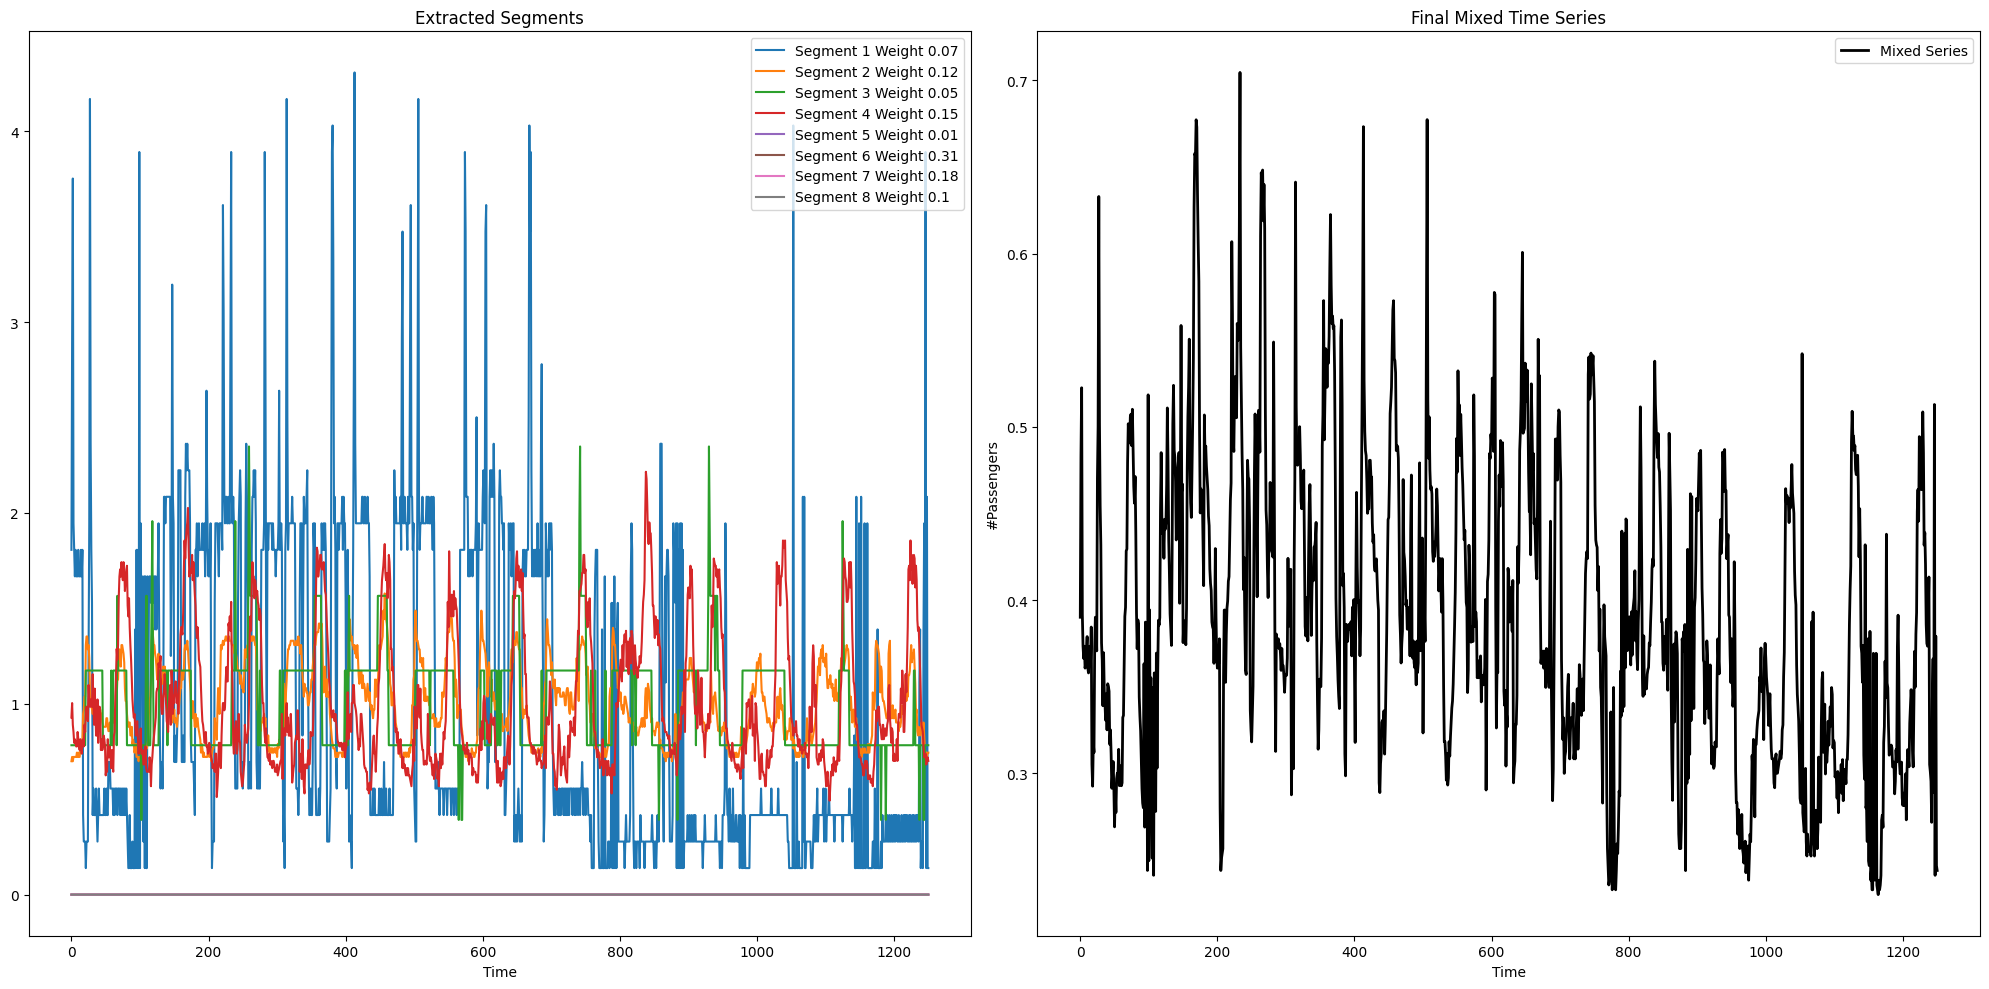

(     #Passengers
 0       0.390087
 1       0.482858
 2       0.522534
 3       0.391575
 4       0.373363
 ...          ...
 1246    0.512884
 1247    0.241125
 1248    0.379158
 1249    0.246694
 1250    0.243909
 
 [1251 rows x 1 columns],
 array([0.07093076, 0.12272162, 0.05073288, 0.14702616, 0.01069907,
        0.31381638, 0.1812828 , 0.10279032]))

In [ ]:
Time_Series_Dataset = []
for col in df_aus_elec_energy.columns:
    if not col == "Date":
        Time_Series_Dataset.append(df_aus_elec_energy[["Date", col]])
tsMixup(Time_Series_Dataset, 10)

## Database